In [1]:
using Interpolations
using NPZ
using Plots
using PyPlot 
import PyPlot
using LaTeXStrings
using Statistics
using PyCall
using FFTW

In [486]:
filepath = "/net/scratch3/giannis_kx/pixie3d/iter/iter3d/db_new/dt2.scratch./";

In [509]:
include("fftUtils.jl")


Main.fftUtils

In [510]:
using .fftUtils

In [5]:
using Printf

In [196]:
using Plots.PlotMeasures

In [8]:
q = npzread(filepath * "q_mpi.npy");

In [10]:
Bpsi = npzread(filepath * "b_hat_rho_mpi.npy");

In [18]:
# Fourier Transform
F = fft(Bpsi,[2,3]);

In [155]:
# getting the dimensions
rdim = size(Bpsi)[1];
ufdim = size(Bpsi)[2];
fidim = size(Bpsi)[3];
tdim = size(Bpsi)[4];
time_list = LinRange(1,tdim,tdim);
psin_list = LinRange(0,1.0,rdim);
uf_list = LinRange(0,2*pi,ufdim);
fi_list = LinRange(0,2*pi,fidim);
Nn = fidim;
Nm = ufdim;

In [15]:
qPrime = fftUtils.q_prime(q,1/100);

In [20]:
# magnetic perturbation at time steps of most interest:
# t1: just when instability starts
# t2: during instability development
# t3: when instability saturates
# t4: long after saturation
t1 = 52;
t2 = 103;
t3 = 123; 
t4 = 143;
Bt1 = Bpsi[:,:,:,t1];
Bt2 = Bpsi[:,:,:,t2];
Bt3 = Bpsi[:,:,:,t3];
Bt4 = Bpsi[:,:,:,t4];
F1 = F[:,:,:,t1];
F2 = F[:,:,:,t2];
F3 = F[:,:,:,t3];
F4 = F[:,:,:,t4];

In [107]:
t1code = 500;
t2code = 1005;
t3code = 1200;
t4code = 1400;

In [397]:
size(q)

(101, 205)

In [514]:
ns,ms,maxbnm,nisl,misl,isl_width,islands = fftUtils.n_m_max(F2,q,t2);

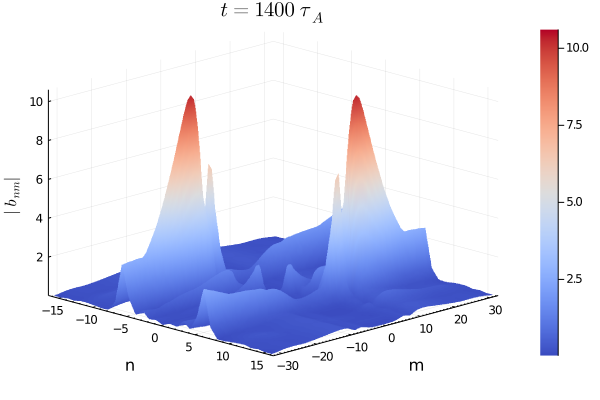

In [502]:
deg = 45
Plots.scatter(ns,ms,maxbnm,zlabel=L"|b_{nm}|",camera=(deg,deg),st=:surface,c=:coolwarm, xlims=(-Nn/2,Nn/2),ylims=(-Nm/2,Nm/2),xminorticks=5,yminorticks=10)
xlabel!("n")
ylabel!("m")
title!(L"t = 1400 \; \tau_{A}")

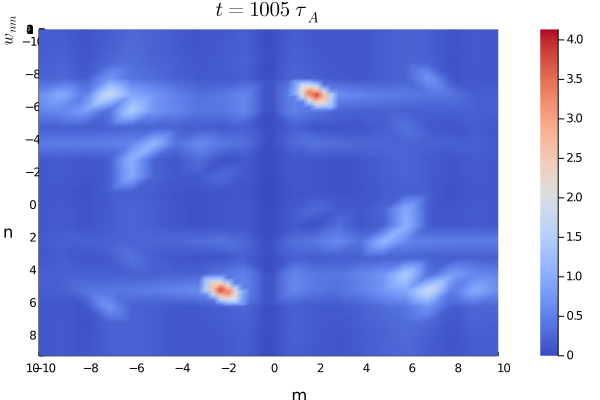

In [515]:
Plots.scatter(nisl,misl,isl_width,zlabel=L"$w_{nm}$",camera=(90,90),st=:surface,c=:coolwarm, #=xlims=(-(Nn/2),Nn/2),ylims=(-Nm/2,Nm/2),xminorticks=5,yminorticks=10=#xlims=(-10,10),ylims=(-10,10),xticks=-10:2:10,yticks=-10:2:10)
xlabel!("n")
ylabel!("m")
title!(L"t = 1005 \; \tau_{A}")

## Island sorting

In [450]:
sort!(islands,by = x->x[3],rev=true);

In [455]:
islands[10:20]

11-element Array{Any,1}:
 (9, 6, 8.422179274425043)
 (-3, 7, 8.208314601620849)
 (3, -7, 8.208314601620849)
 (-8, -5, 6.263802882483759)
 (8, 5, 6.263802882483759)
 (6, 5, 5.540868241213955)
 (-6, -5, 5.540868241213954)
 (-9, -8, 5.48002565337241)
 (9, 8, 5.48002565337241)
 (-5, -3, 4.311577422009411)
 (5, 3, 4.311577422009411)

## Plotting of harmonics

In [391]:
fftUtils.m_mode_num((Nm+1)/2+1,Nm)

32.0

In [156]:
# Construction of grid
m_grid = LinRange(fftUtils.m_mode_num((Nm+1)/2,Nm),fftUtils.m_mode_num((Nm+1)/2+1,Nm),Nm);
psi_grid = LinRange(0,1,size(F)[1]);

In [158]:
# shifting the frequencies to center them to zero and reversing in the theta dimension
sF1 = fftshift(F1,2);
rsF1 = reverse(sF1,dims = 2);
sF2 = fftshift(F2,2);
rsF2 = reverse(sF2,dims = 2);
sF3 = fftshift(F3,2);
rsF3 = reverse(sF3,dims = 2);
sF4 = fftshift(F4,2);
rsF4 = reverse(sF4,dims = 2);

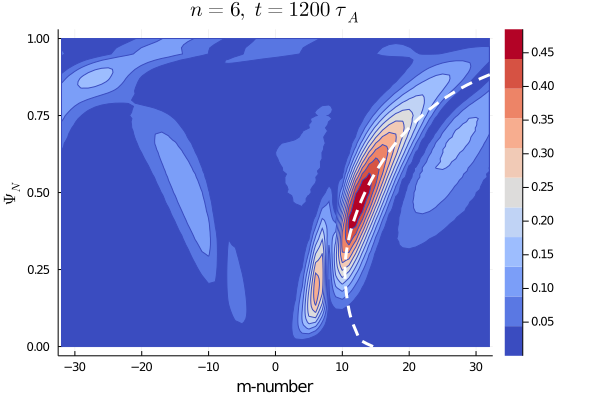

In [475]:
n_harmonic = 7
Plots.contourf(m_grid,psi_grid,abs.(rsF3[:,:,n_harmonic+1]),levels=10,c=:coolwarm,xlim=(-Nm/2,Nm/2),right_margin=10mm)
Plots.plot!(n_harmonic .*q[:,t1],psi_grid,linestyle=:dash,linewidth=3.0,legend=false,c=:white)
title!(L"n=6,\; t = 1200 \;\tau_A")
xlabel!("m-number")
ylabel!(L"\Psi_N")

In [220]:
gr(display_type=:inline)

Plots.GRBackend()

## Movie of modes

In [372]:
ymin = -2.9;
ymax = 1.6;
anim = Plots.Animation()
for t in 1:tdim
    Plots.plot(psi_grid,imag(F[:,fftUtils.m_mode_ind(1,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="red",labels=("m=1,n=1"),legend=:bottomright)
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(2,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="blue",labels=("m=2,n=1"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(3,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="fuchsia",labels=("m=3,n=1"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(3,Nm),fftUtils.n_mode_ind(2,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="slateblue1",labels=("m=3,n=2"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(5,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="green",labels=("m=5,n=1"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(5,Nm),fftUtils.n_mode_ind(2,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="yellow3",labels=("m=5,n=2"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(8,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="salmon",labels=("m=8,n=1"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(8,Nm),fftUtils.n_mode_ind(2,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="orange",labels=("m=8,n=2"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(9,Nm),fftUtils.n_mode_ind(2,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="gold",labels=("m=9,n=2"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(10,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="silver",labels=("m=10,n=1"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(10,Nm),fftUtils.n_mode_ind(2,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="aquamarine",labels=("m=10,n=2"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(8,Nm),fftUtils.n_mode_ind(3,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="black",labels=("m=8,n=3"))
    #Plots.plot!(psin_list,c*imag(bnmt[:,end-2,2,t]),xlims=(0,1),ylims=(-6.8,6.8),color="green",labels=("m=3,n=1"))
    #Plots.plot!(psin_list,c*imag(bnmt[:,end-2,3,t]),xlims=(0,1),ylims=(-6.8,6.8),color="black",labels=("m=3,n=2"))
    #Plots.plot!(psin_list,c*imag(bnmt[:,end-4,4,t]),xlims=(0,1),ylims=(-6.8,6.8),color="blue",labels=("m=5,n=3"))
    #Plots.plot!(psin_list,c*imag(bnmt[:,end-7,5,t]),xlims=(0,1),ylims=(-6.8,6.8),color="magenta",labels=("m=8,n=5"))
    xlabel!(L"$\Psi_n$")
    ylabel!(L"$\textrm{Im}(\hat{b}^{\rho}_{m/n})$")
    time=t
    annotate!((0.9,1.3,"t="*string(time*10)))
    Plots.frame(anim)
end

┌ Info: Saved animation to 
│   fn = /turquoise/users/giannis_kx/Julia/tmp.gif
└ @ Plots /users/giannis_kx/.julia/packages/Plots/Awg62/src/animation.jl:104


Plots.AnimatedGif("/turquoise/users/giannis_kx/Julia/tmp.gif")
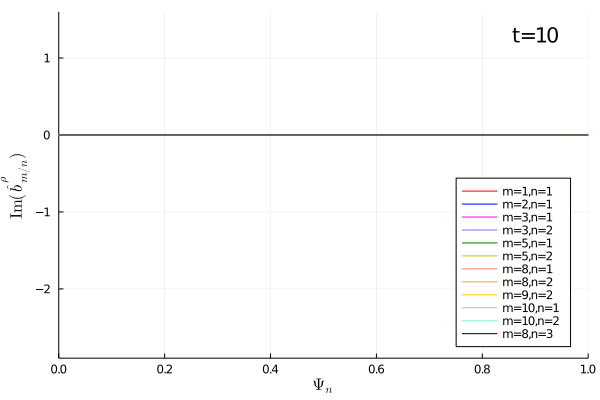

In [373]:
gif(anim,fps=30)

## Plot at the beginning of instability

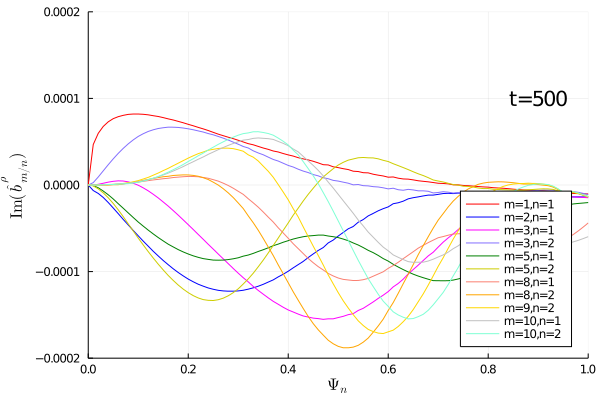

In [363]:
ymin = -0.0002;
ymax = 0.0002;
t=50
Plots.plot(psi_grid,imag(F[:,fftUtils.m_mode_ind(1,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="red",labels=("m=1,n=1"),legend=:bottomright)
Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(2,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="blue",labels=("m=2,n=1"))
Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(3,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="fuchsia",labels=("m=3,n=1"))
Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(3,Nm),fftUtils.n_mode_ind(2,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="slateblue1",labels=("m=3,n=2"))
Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(5,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="green",labels=("m=5,n=1"))
Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(5,Nm),fftUtils.n_mode_ind(2,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="yellow3",labels=("m=5,n=2"))
Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(8,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="salmon",labels=("m=8,n=1"))
Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(8,Nm),fftUtils.n_mode_ind(2,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="orange",labels=("m=8,n=2"))
Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(9,Nm),fftUtils.n_mode_ind(2,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="gold",labels=("m=9,n=2"))
Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(10,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="silver",labels=("m=10,n=1"))
Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(10,Nm),fftUtils.n_mode_ind(2,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="aquamarine",labels=("m=10,n=2"))
#Plots.plot!(psin_list,c*imag(bnmt[:,end-2,2,t]),xlims=(0,1),ylims=(-6.8,6.8),color="green",labels=("m=3,n=1"))
#Plots.plot!(psin_list,c*imag(bnmt[:,end-2,3,t]),xlims=(0,1),ylims=(-6.8,6.8),color="black",labels=("m=3,n=2"))
#Plots.plot!(psin_list,c*imag(bnmt[:,end-4,4,t]),xlims=(0,1),ylims=(-6.8,6.8),color="blue",labels=("m=5,n=3"))
#Plots.plot!(psin_list,c*imag(bnmt[:,end-7,5,t]),xlims=(0,1),ylims=(-6.8,6.8),color="magenta",labels=("m=8,n=5"))
xlabel!(L"$\Psi_n$")
ylabel!(L"$\textrm{Im}(\hat{b}^{\rho}_{m/n})$")

annotate!((0.9,0.0001,"t="*string(t*10)))

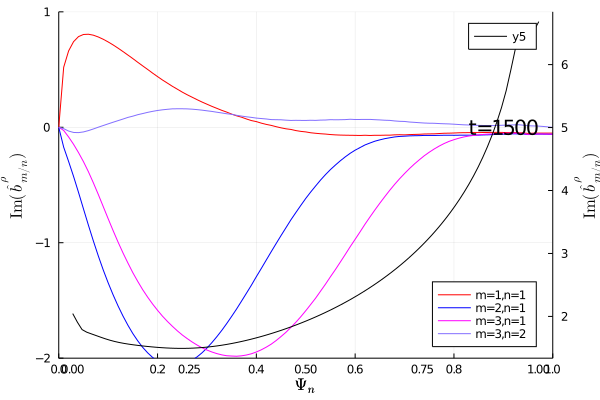

In [420]:
ymin = -2.0002;
ymax = 1.0002;
t=150
Plots.plot(psi_grid,imag(F[:,fftUtils.m_mode_ind(1,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="red",labels=("m=1,n=1"),legend=:bottomright,right_margin=10mm)
Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(2,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="blue",labels=("m=2,n=1"))
Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(3,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="fuchsia",labels=("m=3,n=1"))
Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(3,Nm),fftUtils.n_mode_ind(2,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="slateblue1",labels=("m=3,n=2"))
Plots.plot!(Plots.twinx(),psi_grid,q[:,t],color="black",right_margin=10mm)
xlabel!(L"$\Psi_n$")
ylabel!(L"$\textrm{Im}(\hat{b}^{\rho}_{m/n})$")

annotate!((0.9,0.0001,"t="*string(t*10)))

## Movie of modes of largest islands

In [465]:
ymin = -7.2;
ymax = 6.6;
anim = Plots.Animation()
for t in 50:tdim
    Plots.plot(psi_grid,imag(F[:,fftUtils.m_mode_ind(2,Nm),fftUtils.n_mode_ind(-6,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="red",labels=("m=2,n=-6"),legend=:bottomright)
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(2,Nm),fftUtils.n_mode_ind(1,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="blue",labels=("m=2,n=1"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(7,Nm),fftUtils.n_mode_ind(6,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="fuchsia",labels=("m=7,n=6"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(2,Nm),fftUtils.n_mode_ind(-7,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="slateblue1",labels=("m=2,n=-7"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(9,Nm),fftUtils.n_mode_ind(6,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="green",labels=("m=9,n=6"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(3,Nm),fftUtils.n_mode_ind(-7,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="yellow3",labels=("m=3,n=-7"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(8,Nm),fftUtils.n_mode_ind(5,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="salmon",labels=("m=8,n=5"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(6,Nm),fftUtils.n_mode_ind(5,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="orange",labels=("m=6,n=5"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(9,Nm),fftUtils.n_mode_ind(8,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="gold",labels=("m=9,n=8"))
    Plots.plot!(psi_grid,imag(F[:,fftUtils.m_mode_ind(5,Nm),fftUtils.n_mode_ind(3,Nn),t]),xlims=(0,1),ylims=(ymin,ymax),color="silver",labels=("m=5,n=3"))
    xlabel!(L"$\Psi_n$")
    ylabel!(L"$\textrm{Im}(\hat{b}^{\rho}_{m/n})$")
    time=t
    annotate!((0.9,1.3,"t="*string(time*10)))
    Plots.frame(anim)
end

┌ Info: Saved animation to 
│   fn = /turquoise/users/giannis_kx/Julia/tmp.gif
└ @ Plots /users/giannis_kx/.julia/packages/Plots/Awg62/src/animation.jl:104


Plots.AnimatedGif("/turquoise/users/giannis_kx/Julia/tmp.gif")
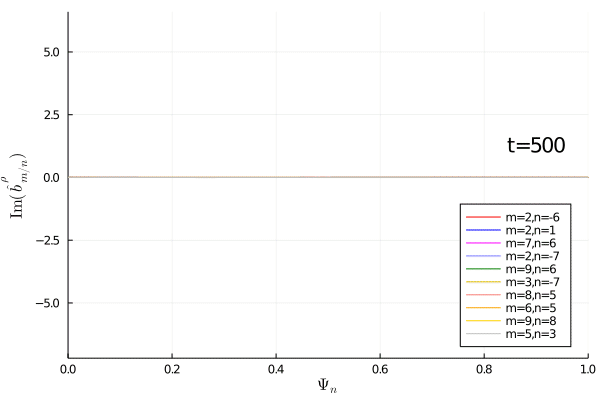

In [466]:
gif(anim,fps=30)